In [ ]:
%matplotlib inline


# 1 - Getting Started

The main application for :mod:`scikit-gstat <skgstat>` is variogram analysis and `Kriging <https://en.wikipedia.org/wiki/Kriging>`_.
This tutorial will guide you through the most basic functionality of ``scikit-gstat``.
There are other tutorials that will explain specific methods or attributes in ``scikit-gstat`` in more detail.

**What you will learn in this tutorial**

    * How to instantiate :class:`Variogram <skgstat.Variogram>` and :class:`OrdinaryKriging <skgstat.OrdinaryKriging>`
    * How to read a variogram
    * Perform an interpolation
    * Most basic plotting


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
import warnings
warnings.filterwarnings("ignore")

The module is called ``skgstat`` and by convention imported as ``skg``.
The :class:`Variogram <skgstat.Variogram>` and :class:`OrdinaryKriging <skgstat.OrdinaryKriging>` classes are available at top level.



In [5]:
import skgstat as skg

## 1.1 Load data
SciKit-GStat includes a data submodule, that contains some sample datasets. It also offers some basic random sampling on data sources.
Here we use the well-known Meuse dataset from the R package ``sp`` (https://cran.r-project.org/web/packages/st/index.html). 
If not specified different, the loading function will only export the lead measurements from the data source.

**Note:** The data is distributed along with the package sp under a GPL-3 license.
If you use the data, cite the original authors, not SciKit-GStat for the dataset.



In [ ]:
src = skg.data.meuse()
print(src.get('origin'))

coords, vals = src.get('sample')
# make a nice table
pd.DataFrame({'x': coords[:, 0], 'y': coords[:, 1], 'lead': vals.flatten()}).head()

Sample dataset of real measurements of heavy metal pollutions
    in the topsoil on a 15x15 meter plot along the river Meuse.
    The data is distributed along with the R-package sp.
    IMPORTANT: If you use this data, cite Pebesma and Bivand (2005)
    and Bivand et al (2013):

      Pebesma EJ, Bivand RS (2005). “Classes and methods for spatial
      data in R.” R News, 5(2), 9–13. https://CRAN.R-project.org/doc/Rnews/.

      Bivand RS, Pebesma E, Gomez-Rubio V (2013). Applied spatial data
      analysis with R, Second edition. Springer, NY. https://asdar-book.org/.

    
2


,x,y,lead
0,181072,333611,299
1,181025,333558,277
2,181165,333537,199
3,181298,333484,116
4,181307,333330,117


Get a first overview of your data by plotting the `x` and `y` coordinates and visually inspect how the `z` spread out.



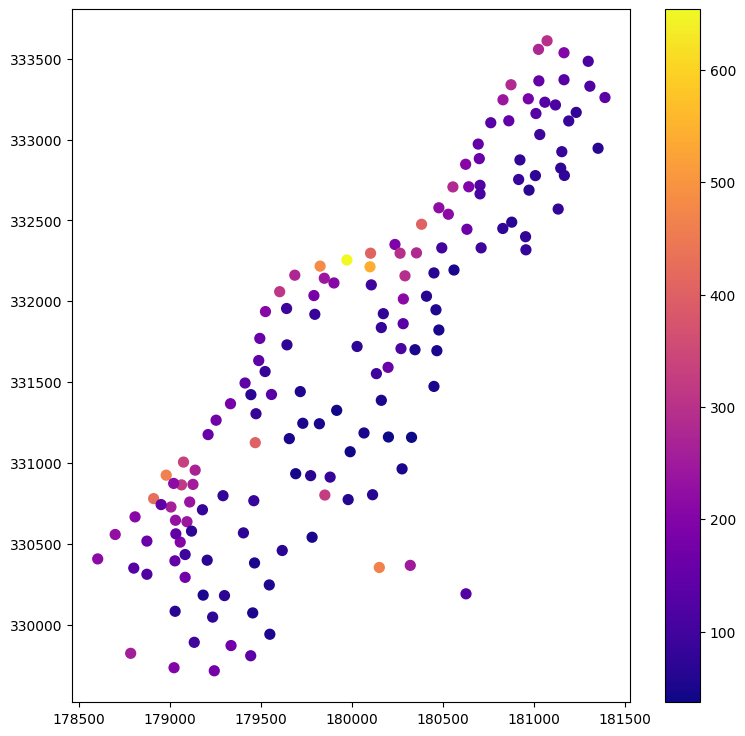

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(9, 9))
art = ax.scatter(coords[:, 0], coords[:, 1], s=50, c=vals.flatten(), cmap='plasma')
plt.colorbar(art)
plt.show()

We can already see a lot from here:

* There are a few hot-spots, most of them aligned along the river-bank.
* Most observations show rather low values

These are already very important insights.

## 1.2 Build a Variogram
As a quick reminder, the variogram relates pair-wise separating distances of `coordinates` and relates them to the *semi-variance* of the corresponding `values` pairs. The default estimator used is the Matheron estimator:

\begin{align}\gamma (h) = \frac{1}{2N(h)} * \sum_{i=1}^{N(h)}(Z(x_i) - Z(x_{i + h}))^2\end{align}

For more details, please refer to the `User Guide <https://mmaelicke.github.io/scikit-gstat/userguide/variogram.html#experimental-variograms>`_.

The :class:`Variogram <skgstat.Variogram>` class takes at least two arguments. 
The :func:`coordinates <skgstat.Variogram.coordinates>` and the :func:`values <skgstat.Variogram.values>` observed at these locations.
If you use older versions, <ou should also at least set the ``normalize`` parameter to explicitly, as it changed it's default value in
version `0.2.8` to ``False``. This attribute affects only the plotting, not the variogram values.
Additionally, the number of bins is set to 15, because we have fairly many observations and the default value of 10 is unnecessarily small.
The ``maxlag`` set the maximum distance for the last bin. As we have no other additional information about expected correlation lengths,
we can either set nothing and use the full distance matrix, or set it i.e. to ``'median'``, which will restrict the distance matrix to only
use half of all combinations.



In [8]:
V = skg.Variogram(coords, vals.flatten(), maxlag='median', n_lags=15, normalize=False)
fig = V.plot(show=False)

The upper subplot show the histogram for the count of point-pairs in each lag class. You can see various things here:

  * As expected, there is a clear spatial dependency, because semi-variance increases with distance (blue dots)
  * The default `spherical` variogram model is well fitted to the experimental data
  * The shape of the dependency is **not** captured quite well, but fair enough for this example
  * The first two bins are not well captured, suggesting either the use of a nugget, or a different model.

The sill of the variogram should correspond with the field variance. The field is unknown, but we can compare the sill to the *sample* variance:



In [9]:
print('Sample variance: %.2f   Variogram sill: %.2f' % (vals.flatten().var(), V.describe()['sill']))

Sample variance: 12312.20   Variogram sill: 16066.26


The ``describe`` method will return the most important parameters as a dictionary. 
And we can simply print the variogram ob,ect to the screen, to see all parameters.



In [10]:
pprint(V.describe())

{'dist_func': 'euclidean',
 'effective_range': 948.7297703307589,
 'estimator': 'matheron',
 'kwargs': {},
 'model': 'spherical',
 'normalized_effective_range': 1302289.1170443997,
 'normalized_nugget': 0,
 'normalized_sill': 284534314.95439684,
 'nugget': 0,
 'params': {'bin_func': 'even',
            'dist_func': 'euclidean',
            'estimator': 'matheron',
            'fit_method': 'trf',
            'fit_sigma': None,
            'maxlag': 1372.6660191029719,
            'model': 'spherical',
            'n_lags': 15,
            'normalize': False,
            'use_nugget': False,
            'verbose': False},
 'sill': 16066.258403776985}


An even shorter summary is printed by the :class:`Variogram <skgstat.Variogram>` object itself:



In [11]:
print(V)

spherical Variogram
-------------------
Estimator:         matheron
Effective Range:   948.73
Sill:              16066.26
Nugget:            0.00
        


## 1.3 Kriging
The Kriging class will now use the Variogram from above to estimate the Kriging weights for each grid cell. This is done by solving a linear equation system. For an unobserved location $s_0$, we can use the distances to 5 observation points and build the system like:

\begin{align}\begin{pmatrix}
  \gamma(s_1, s_1) & \gamma(s_1, s_2) & \gamma(s_1, s_3) & \gamma(s_1, s_4) & \gamma(s_1, s_5) & 1\\
  \gamma(s_2, s_1) & \gamma(s_2, s_2) & \gamma(s_2, s_3) & \gamma(s_2, s_4) & \gamma(s_2, s_5) & 1\\
  \gamma(s_3, s_1) & \gamma(s_3, s_2) & \gamma(s_3, s_3) & \gamma(s_3, s_4) & \gamma(s_3, s_5) & 1\\
  \gamma(s_4, s_1) & \gamma(s_4, s_2) & \gamma(s_4, s_3) & \gamma(s_4, s_4) & \gamma(s_4, s_5) & 1\\
  \gamma(s_5, s_1) & \gamma(s_5, s_2) & \gamma(s_5, s_3) & \gamma(s_5, s_4) & \gamma(s_5, s_5) & 1\\
  1 & 1 & 1 & 1 & 1 & 0 \\
  \end{pmatrix} *
  \begin{bmatrix}
  \lambda_1 \\
  \lambda_2 \\
  \lambda_3 \\
  \lambda_4 \\
  \lambda_5 \\
  \mu \\
  \end{bmatrix} =
  \begin{pmatrix}
  \gamma(s_0, s_1) \\
  \gamma(s_0, s_2) \\
  \gamma(s_0, s_3) \\
  \gamma(s_0, s_4) \\
  \gamma(s_0, s_5) \\
  1 \\
  \end{pmatrix}\end{align}

For more information, please refer to the `User Guide <https://mmaelicke.github.io/scikit-gstat/userguide/kriging.html#kriging-equation-system>`_.

Consequently, the :class:`OrdinaryKriging <skgstat.OrdinaryKriging>` class needs a :class:`Variogram <skgstat.Variogram>` 
object as a mandatory attribute. Two very important optional attributes are ``min_points`` and ``max_points```.
They will limit the size of the Kriging equation system. As we have 200 observations,
we can require at least 5 neighbors within the range. More than 15 will only unnecessarily slow down the computation.
The ``mode='exact'`` attribute will advise the class to build and solve the system above for each location.

**Note:** The recommended way for kriging applications is to use the interface to :any:`gstools`.
There is an easy-to-use interface via :func:`Variogram.to_gstools <skgstat.Variogram.to_gstools>` 
and :func:`Variogram.to_gs_krige <skgstat.Variogram.to_gs_krige>`.
The getting started tutorial will use the builtin kriging class, anyway.



In [12]:
ok = skg.OrdinaryKriging(V, min_points=5, max_points=15, mode='exact')

The :func:`OrdinaryKriging.transform <skgstat.OrdianryKriging.transform>` method will apply the interpolation for passed arrays of coordinates.
It requires each dimension as a single 1D array. We can easily build a meshgrid of 100x100 coordinates and pass them to the interpolator.
To recieve a 2D result, we can simply reshape the result. The Kriging error will be available as the ``sigma`` attribute of the interpolator.



In [13]:
# build the target grid
x = coords[:, 0]
y = coords[:, 1]
xx, yy = np.mgrid[x.min():x.max():100j, y.min():y.max():100j]
field = ok.transform(xx.flatten(), yy.flatten()).reshape(xx.shape)
s2 = ok.sigma.reshape(xx.shape)

And finally, we can plot the result.



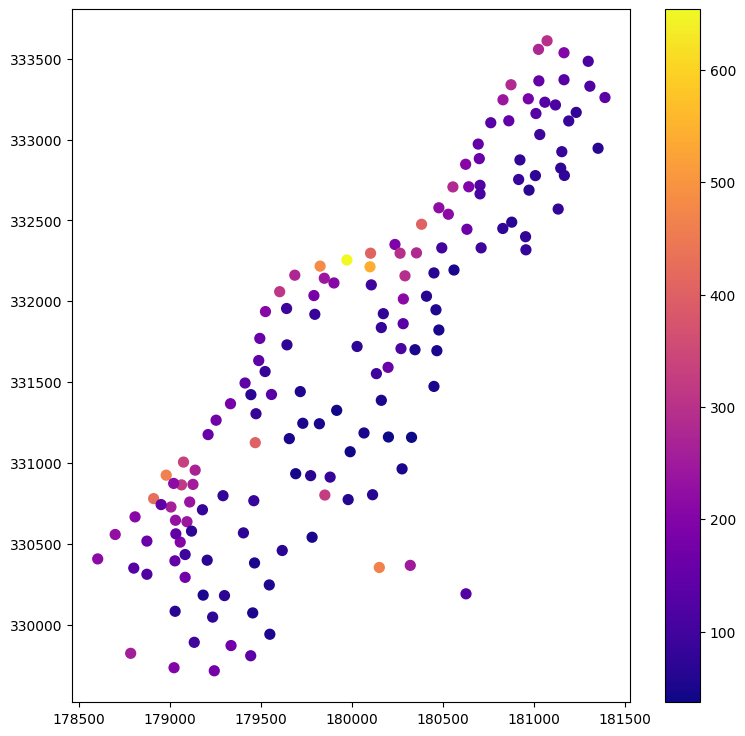

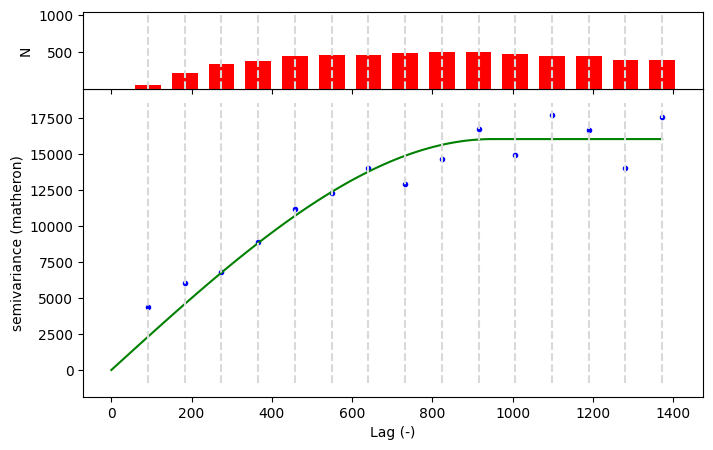

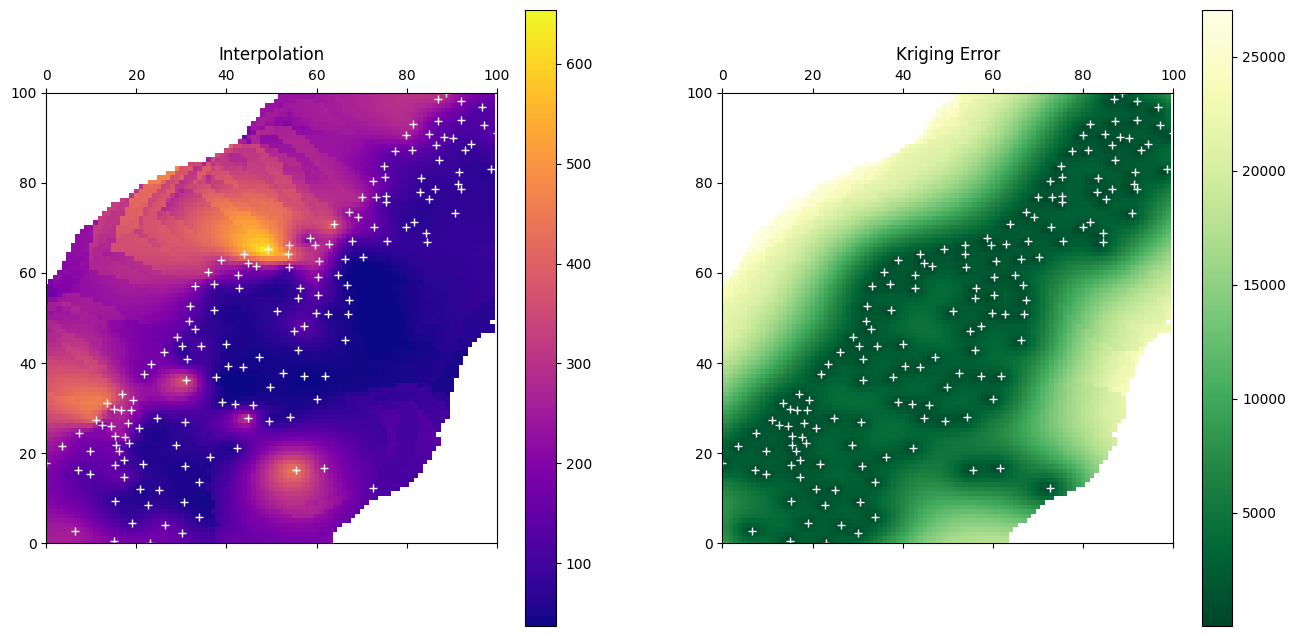

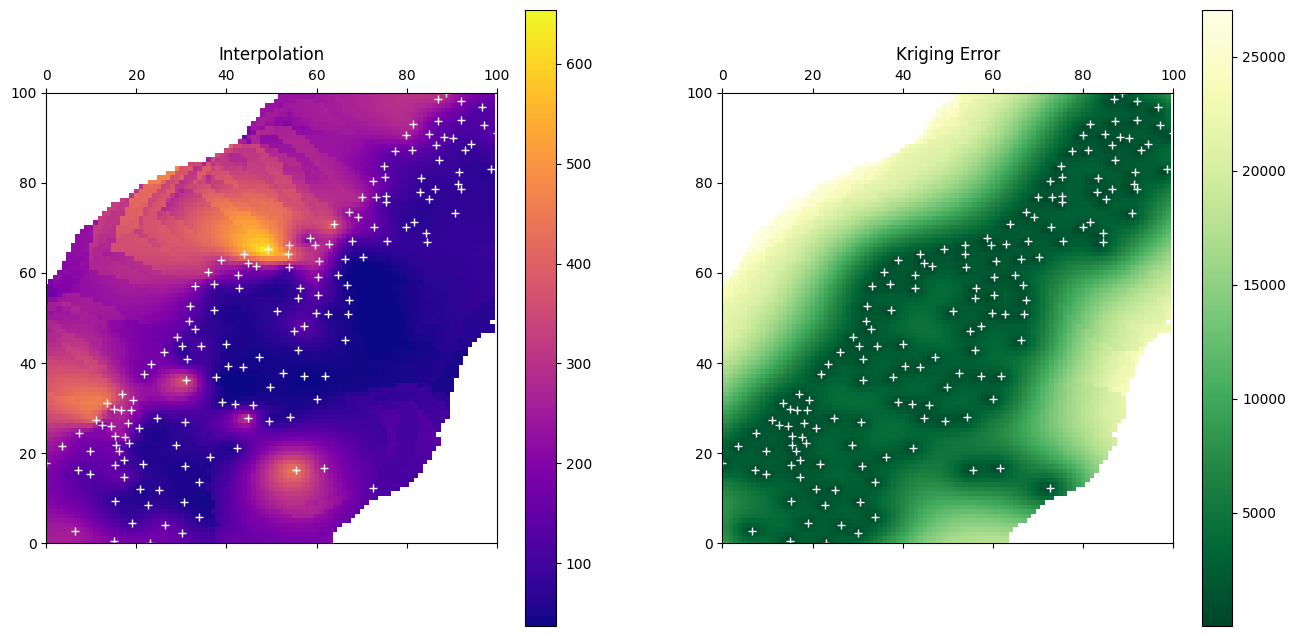

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# rescale the coordinates to fit the interpolation raster
x_ = (x - x.min()) / (x.max() - x.min()) * 100
y_ = (y - y.min()) / (y.max() - y.min()) * 100

art = axes[0].matshow(field.T, origin='lower', cmap='plasma', vmin=vals.min(), vmax=vals.max())
axes[0].set_title('Interpolation')
axes[0].plot(x_, y_, '+w')
axes[0].set_xlim((0, 100))
axes[0].set_ylim((0, 100))
plt.colorbar(art, ax=axes[0])
art = axes[1].matshow(s2.T, origin='lower', cmap='YlGn_r')
axes[1].set_title('Kriging Error')
plt.colorbar(art, ax=axes[1])
axes[1].plot(x_, y_, '+w')
axes[1].set_xlim((0, 100))
axes[1].set_ylim((0, 100))

plt.show()

From the Kriging error map, you can see how the interpolation is very certain close to the observation points,
but rather high in areas with only little coverage. You could now define a threshold of maximum accepted Kriging error
variance to mask the interpolation result.

